In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

%matplotlib inline
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery
import glob

credential_path = glob.glob(r'../../BQ_Keypath/*.json')
client = bigquery.Client.from_service_account_json(credential_path[0])

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

## Section 1. Daily Active User Metric. 
- DAU = total unique active users(signin, create a comment, question or an answer to a question) in a given day. 
- Tables: 
    - _user_
    - _comments_
    - _posts_questions_
    - _post_answers_ 

In [3]:
# looking into comments, question and answer tables schema
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_questions')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, (), None),
 Sch

In [4]:
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_answers')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, (), None),
 Schema

In [5]:
schema = getTableSchema('bigquery-public-data.stackoverflow.comments')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, (), None)]

In [6]:
schema = getTableSchema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, (), None)]

In [9]:
from google.cloud.exceptions import NotFound

# combining tables for access later
# fields we want: date, day of the week, user id, activity type, 
view_id = "portfolio-331917.stored_views.active_users"

try:
    client.get_table(view_id)
    print('view already exist, skipping')
except NotFound:
    view = bigquery.Table(view_id)
    view.view_query = f"""
                        SELECT
                            DATE(creation_date) AS active_date,
                            FORMAT_DATE("%a", DATE(creation_date)) AS weekday,
                            owner_user_id,
                            "question" AS activity_type
                        FROM `bigquery-public-data.stackoverflow.posts_questions`
                        WHERE
                            NOT creation_date IS NULL 
                        UNION ALL 
                        SELECT
                           DATE(creation_date) AS active_date,
                            FORMAT_DATE("%a", DATE(creation_date)) AS weekday,
                            owner_user_id,
                            "answer" AS activity_type
                        FROM `bigquery-public-data.stackoverflow.posts_answers`
                        WHERE
                            NOT creation_date IS NULL 
                        UNION ALL 
                        SELECT
                            DATE(creation_date) AS active_date,
                            FORMAT_DATE("%a", DATE(creation_date)) AS weekday,
                            user_id AS owner_user_id,
                            "comment" AS activity_type
                        FROM `bigquery-public-data.stackoverflow.comments`
                        WHERE
                            NOT creation_date IS NULL
                        UNION ALL 
                        SELECT
                           DATE(last_access_date) AS active_date,
                            FORMAT_DATE("%a", DATE(last_access_date)) AS weekday,
                            id AS owner_user_id,
                            "signin" AS activity_type
                        FROM `bigquery-public-data.stackoverflow.users`
                        WHERE
                            NOT last_access_date IS NULL
                        """
    view = client.create_table(view)

view already exist, skipping


In [10]:
# quick null checking to ensure the table is null free
query = """
        SELECT 
            *
        FROM `portfolio-331917.stored_views.active_users`
        WHERE 
            active_date IS NULL 
            OR owner_user_id IS NULL 
        """

result = getQueryAsDF(query)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961555 entries, 0 to 1961554
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   active_date    object
 1   weekday        object
 2   owner_user_id  object
 3   activity_type  object
dtypes: object(4)
memory usage: 59.9+ MB


great, none of the fields have any null value and they are assigned to appropriate data typed. 

In [40]:
# getting dau for the last 30 days
query = """
        SELECT 
            active_date,
            COUNT(DISTINCT owner_user_id) AS dau,
        FROM `portfolio-331917.stored_views.active_users`
        WHERE 
            active_date BETWEEN DATE '2019-09-01' AND DATE '2019-09-30' 
        GROUP BY 1
        ORDER BY 1 DESC 
        """

df_dau = getQueryAsDF(query)
df_dau

,active_date,dau
0,2019-09-30,19982
1,2019-09-29,10858
2,2019-09-28,10431
3,2019-09-27,20365
4,2019-09-26,21833
5,2019-09-25,22062
6,2019-09-24,21726
7,2019-09-23,20300
8,2019-09-22,10770
9,2019-09-21,10276


In [39]:
df_dau.describe()

,dau
count,30.000000
mean,17257.633333
std,4801.373887
min,9665.000000
25%,10792.000000
50%,19765.000000
75%,20702.750000
max,22062.000000


Text(0.5, 1.0, 'DAU past 30 days')

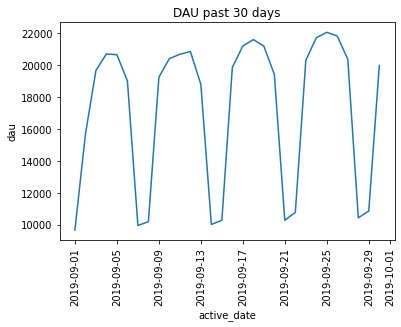

In [42]:
sns.lineplot(data = df_dau, x = 'active_date', y = 'dau')
plt.xticks(rotation = 90)
plt.title("DAU past 30 days")

In [3]:
# dau by cohorts
query = """
        WITH cohort AS
        (
            SELECT 
                active_date,
                owner_user_id,
                CASE 
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) <= 7 THEN "1 WEEK"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 8 AND 14 THEN "2 WEEKS"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 15 AND 21 THEN "3 WEEKS"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 22 AND 28 THEN "4 WEEKS"
                    ELSE "5+ WEEKS"
                END AS week_join
            FROM `portfolio-331917.stored_views.active_users` AS a
                JOIN `bigquery-public-data.stackoverflow.users` AS u 
                ON a.owner_user_id = u.id
            WHERE 
                active_date BETWEEN DATE '2019-09-01' AND  DATE '2019-09-30'
                AND active_date > DATE(creation_date)
            ORDER BY 1
        )
 
        SELECT active_date, week_join, COUNT(DISTINCT owner_user_id) AS dau FROM cohort GROUP BY 1,2 ORDER BY 1,2 DESC
        """

result = getQueryAsDF(query)
result

,active_date,week_join,dau
0,2019-09-01,5+ WEEKS,8619
1,2019-09-02,5+ WEEKS,14415
2,2019-09-03,5+ WEEKS,17904
3,2019-09-03,4 WEEKS,223
4,2019-09-04,5+ WEEKS,18683
...,...,...,...
95,2019-09-30,5+ WEEKS,16419
96,2019-09-30,4 WEEKS,201
97,2019-09-30,3 WEEKS,256
98,2019-09-30,2 WEEKS,361


Text(0.5, 1.0, 'DAU by cohorts')

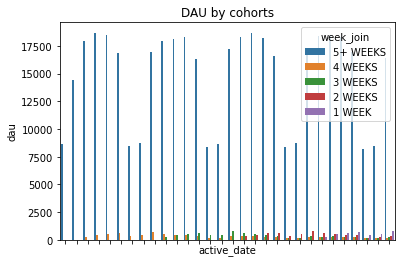

In [4]:
sns.barplot(data = result, x = 'active_date', y = 'dau', hue = "week_join")
plt.tick_params(labelbottom = False)
plt.title("DAU by cohorts")

In [5]:
# exclude 5+ week to narrow down churn rate

query = """
        WITH cohort AS
        (
            SELECT 
                active_date,
                owner_user_id,
                CASE 
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 0 AND 7 THEN "1 WEEK"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 8 AND 14 THEN "2 WEEKS"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 15 AND 21 THEN "3 WEEKS"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) BETWEEN 22 AND 28 THEN "4 WEEKS"
                    WHEN DATE_DIFF(DATE '2019-09-30', DATE(creation_date), DAY) > 28 THEN "5+ WEEKS"
                END AS week_join
            FROM `portfolio-331917.stored_views.active_users` AS a
                JOIN `bigquery-public-data.stackoverflow.users` AS u 
                ON a.owner_user_id = u.id
            WHERE 
                active_date BETWEEN DATE '2019-09-01' AND  DATE '2019-09-30'
                AND active_date > DATE(creation_date)
            ORDER BY 1
        )

        SELECT 
            active_date,
            week_join, 
            COUNT(DISTINCT owner_user_id) AS dau 
        FROM cohort  
        GROUP BY 1,2
        HAVING 
            NOT week_join LIKE '5+%'   
        ORDER BY 1,2 DESC
        """

result = getQueryAsDF(query)
result

,active_date,week_join,dau
0,2019-09-03,4 WEEKS,223
1,2019-09-04,4 WEEKS,407
2,2019-09-05,4 WEEKS,548
3,2019-09-06,4 WEEKS,652
4,2019-09-07,4 WEEKS,373
...,...,...,...
65,2019-09-29,1 WEEK,518
66,2019-09-30,4 WEEKS,201
67,2019-09-30,3 WEEKS,256
68,2019-09-30,2 WEEKS,361


Text(0.5, 1.0, 'DAU by cohorts')

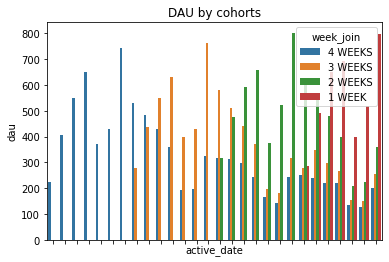

In [6]:
sns.barplot(data = result, x = 'active_date', y = 'dau', hue = "week_join")
plt.tick_params(labelbottom = False)
plt.title("DAU by cohorts")